In [1]:
path = './sales_log/'

Create a Schema

In [2]:
from pyspark.sql.types import *

salesSchema = StructType([
    StructField("OrderID", DoubleType(), True),
    StructField("OrderDate", StringType(), True),
    StructField("Quantity", DoubleType(), True),
    StructField("DiscountPct", DoubleType(), True),
    StructField("Rate", DoubleType(), True),
    StructField("SaleAmount", DoubleType(), True),
    StructField("CustomerName", StringType(), True),
    StructField("State", StringType(), True),
    StructField("Region", StringType(), True),
    StructField("ProductKey", StringType(), True),
    StructField("RowCount", DoubleType(), True),
    StructField("ProfitMargin", DoubleType(), True)
]) 

In [3]:
data = (
    spark
        .read
        .schema(salesSchema)
        .csv(path)
)

In [5]:
data.show()

+-------+---------+--------+-----------+-----+----------+------------------+-----------+-------+--------------------+--------+------------+
|OrderID|OrderDate|Quantity|DiscountPct| Rate|SaleAmount|      CustomerName|      State| Region|          ProductKey|RowCount|ProfitMargin|
+-------+---------+--------+-----------+-----+----------+------------------+-----------+-------+--------------------+--------+------------+
|44935.0| 11/17/10|    37.0|       0.06|200.0|    7011.4|     Arthur Nelson| New Mexico|   West| Development - Scala|     1.0|        0.65|
|44935.0| 11/17/10|    37.0|       0.01|140.0|   5169.04|     Arthur Nelson|    Florida|  South|Development - Dat...|     1.0|        0.64|
| 2563.0| 11/18/10|    12.0|       0.04|200.0|   2322.41| Brenda Hildebrand|Mississippi|  South| Development - Scala|     1.0|        0.74|
| 2563.0| 11/18/10|    33.0|       0.01|120.0|   3951.72| Brenda Hildebrand|Mississippi|  South|Development - Bus...|     1.0|        0.44|
| 2752.0| 11/18/10| 

In [6]:
data.createOrReplaceTempView("sales")

In [8]:
spark.sql("select * from sales").show()

+-------+---------+--------+-----------+-----+----------+------------------+-----------+-------+--------------------+--------+------------+
|OrderID|OrderDate|Quantity|DiscountPct| Rate|SaleAmount|      CustomerName|      State| Region|          ProductKey|RowCount|ProfitMargin|
+-------+---------+--------+-----------+-----+----------+------------------+-----------+-------+--------------------+--------+------------+
|44935.0| 11/17/10|    37.0|       0.06|200.0|    7011.4|     Arthur Nelson| New Mexico|   West| Development - Scala|     1.0|        0.65|
|44935.0| 11/17/10|    37.0|       0.01|140.0|   5169.04|     Arthur Nelson|    Florida|  South|Development - Dat...|     1.0|        0.64|
| 2563.0| 11/18/10|    12.0|       0.04|200.0|   2322.41| Brenda Hildebrand|Mississippi|  South| Development - Scala|     1.0|        0.74|
| 2563.0| 11/18/10|    33.0|       0.01|120.0|   3951.72| Brenda Hildebrand|Mississippi|  South|Development - Bus...|     1.0|        0.44|
| 2752.0| 11/18/10| 

In [16]:
p = spark.sql("select ProductKey as Products, round(sum(SaleAmount)) as TotalSales from sales group by ProductKey order by 2 desc")

<AxesSubplot:xlabel='Products'>

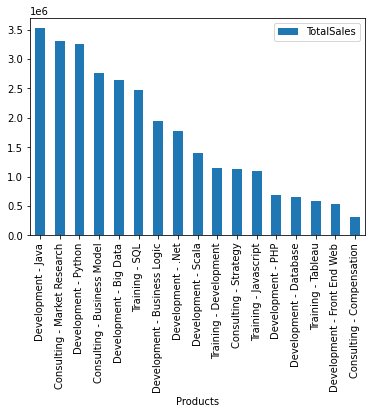

In [37]:
p.toPandas().plot.bar(x = "Products")

In [38]:
from pyspark.sql.functions import *

In [39]:
streamInputDF = (
    spark
        .readStream
        .schema(salesSchema)
        .option("maxFilesPerTrigger",1)
        .csv(path)
)

In [41]:
streamingCountDF = (
    streamInputDF
        .select("ProductKey", "saleAmount")
        .groupBy("ProductKey")
        .sum()
)

In [42]:
streamingCountDF.isStreaming

True

In [45]:
type(streamingCountDF)

pyspark.sql.dataframe.DataFrame

In [46]:
query = (
    streamingCountDF
    .writeStream
    .format("memory")
    .queryName("sales_stream")
    .outputMode("complete")
    .start()
)

22/06/10 15:04:13 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-ea940399-ed3c-4b28-bf8b-2f2286f8dd3e. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
22/06/10 15:04:13 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


<AxesSubplot:>

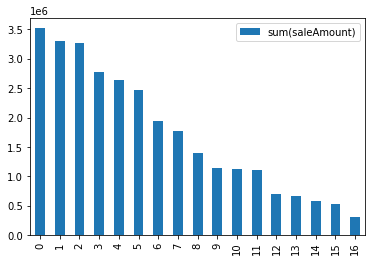

In [54]:
q = spark.sql("select * from sales_stream order by 2 desc")
q.toPandas().plot.bar()